<div style="display:block" direction=rtl align=right><br><br>
    <div  style="width:100%;margin:100;display:block"  display=block align=center>
        <img width=130 align=right src="https://i.ibb.co/yXKQmtZ/logo1.png" style="margin:0;" />
        <img width=170 align=left  src="https://i.ibb.co/wLjqFkw/logo2.png" style="margin:0;" />
        <span><br><font size=5>University of Tehran , school of ECE</font></span>
        <span><br><font size=3>Data Analytics Course</font></span>
        <span><br><font size=3>Fall 2022</font></span>
    </div><br><br><br>
    <div style="display:block" align=left display=block> 
        <font size=3>Homework 4</font><br>
        <hr />
        <font size=3>TA: <a href="mailto:p.zilouchian@ut.ac.ir">Parham Zilouchian</a><br></font><br>
    </div>
</div>

# **Working with Database Systems**

## **Part1 - EDA and Visualization**

#### **Section 1. Just some points :)**

In [42]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from hazm import *
import arabic_reshaper
from bidi.algorithm import get_display

plt.style.use("ggplot")


def read_births(year: int, season=0) -> pd.DataFrame:
    path = f"./Datasets/Part1/veladat-{year}.xlsx"
    season_en_to_fa = {
        "spring": "بهار",
        "summer": "تابستان",
        "fall": "پاییز",
        "winter": "زمستان"
    }
    df_dict = dict()
    df = pd.read_excel(path, sheet_name=season_en_to_fa[season])
    skip_idx = 3
    df_dict["province"] = list(df.loc[skip_idx:, "Unnamed: 1"])
    df_dict["total"] = (df.loc[skip_idx:, "Unnamed: 2"])
    df_dict["male"] = (df.loc[skip_idx:, "Unnamed: 3"])
    df_dict["female"] = (df.loc[skip_idx:, "Unnamed: 4"])
    df_dict["season"] = [str(season)] * len(df_dict["province"])
    df_dict["year"] = [year] * len(df_dict["province"])
    df = pd.DataFrame(df_dict)
    normalizer = Normalizer()
    df["province"] = df["province"].apply(normalizer.normalize)
    return df

def read_population() -> pd.DataFrame:
    df = pd.read_csv("./Datasets/Part1/Iran_population.csv")
    df.columns = ['province', 'population']
    normalizer = Normalizer()
    df["province"] = df["province"].apply(normalizer.normalize)
    return df

df = read_births(95, "spring")
df = read_population()
df

,province,population
0,آذربایجان شرقی,4018000
1,آذربایجان غربی,3398000
2,اردبیل,1297000
3,اصفهان,5292000
4,البرز,2865000
5,ایلام,597000
6,بوشهر,1230000
7,تهران,13807000
8,چهارمحال وبختیاری,979000
9,خراسان جنوبی,809000


<blockquote>
    
Here we first read the two files and make an organaized dataframe from them to later add them to the database.
We also normalize the province name which in some cases use different characters to match the two datasets.

#### **Section 2. Write Query using Psycopg2**

```
# This is formatted as code
```



In [3]:
class DB:
    def __init__(self):
        self.conn = None
        self.__create_tables()
    
    def execute(self, command, close_after=False):
        try:
            if self.conn is None:
                self.conn = psycopg2.connect(database="mohsen_db", user="postgres", password="1234", host="localhost")
            self.conn = self.conn
            curser = self.conn.cursor()
            curser.execute(command)
            curser.close()
            self.conn.commit()
        except(Exception, psycopg2.DatabaseError) as error:
            print(error)
        finally:
            if self.conn is not None:
                if close_after:
                    self.conn.close()
                    self.conn = None
    
    def select(self, command):
        data = None
        try:
            conn = None
            conn = psycopg2.connect(database="mohsen_db", user="postgres",
                                    password="1234", host="localhost")
            curser = conn.cursor()
            curser.execute(command)
            data = curser.fetchall()
            curser.close()
        except(Exception, psycopg2.DatabaseError) as error:
            print(error)
        finally:
            if conn is not None:
                conn.close()
            return data
    
    def __create_tables(self):
        commands = [
            """
            DROP TABLE IF EXISTS births;
            """,
            """
            DROP TABLE IF EXISTS population;
            """,
            """
            CREATE TABLE IF NOT EXISTS population (
                id INT GENERATED ALWAYS AS IDENTITY,
                province VARCHAR(255) NOT NULL,
                population INT NOT NULL,
                PRIMARY KEY (id),
                CONSTRAINT unique0 UNIQUE (province)
            )
            """,
            """
            CREATE TABLE IF NOT EXISTS births (
                id INT GENERATED ALWAYS AS IDENTITY,
                province VARCHAR(255) NOT NULL,
                year INT NOT NULL,
                season VARCHAR(100) NOT NULL,
                total INT NOT NULL,
                male INT NOT NULL,
                female INT NOT NULL,
                PRIMARY KEY (id),
                CONSTRAINT fk_province
                    FOREIGN KEY(province)
                    REFERENCES population(province),
                CONSTRAINT unique1 UNIQUE (province, year, season, total),
                CONSTRAINT unique2 UNIQUE (province, year, season, male),
                CONSTRAINT unique3 UNIQUE (province, year, season, female)
            )
            """
        ]
        for command in commands:
            self.execute(command, close_after=True)
    
    def insert_row(self, row, table, cols):
        values = ",".join([f"'{row[col]}'" for col in cols])
        command = f"INSERT INTO {table}({','.join(cols)}) VALUES ({values}) ON CONFLICT DO NOTHING"
        self.execute(command)
        
    def insert_births(self):
        cols = ["province", "year", "season", "total", "male", "female"]
        for year in tqdm(list(range(91, 100)) + [1400], desc="Insert Births"):
            for season in ["spring", "summer", "fall", "winter"]:
                df = read_births(year, season)
                for index, row in df.iterrows():
                    row["year"] = int("13" + str(year)) if year != 1400 else 1400 
                    db.insert_row(row, "births", cols)
        
    def insert_province_population(self):
        cols = ["province", "population"]
        df = read_population()
        for index, row in tqdm(df.iterrows(), desc="Insert Population", total=len(df)):
            db.insert_row(row, "population", cols)


db = DB()
db.insert_province_population()
db.insert_births()

Insert Population:   0%|          | 0/31 [00:00<?, ?it/s]

Insert Births:   0%|          | 0/10 [00:00<?, ?it/s]

##### **a. Total births**

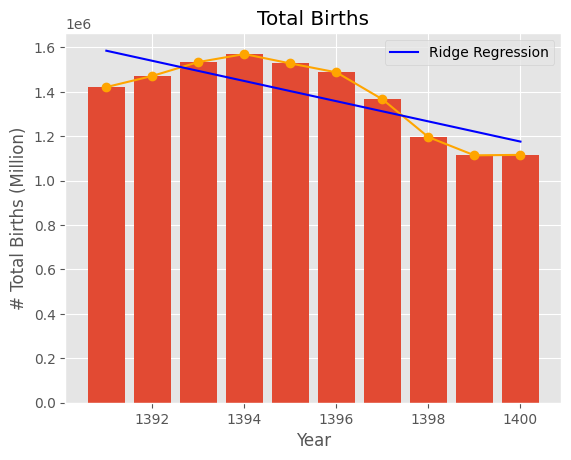

In [12]:
from sklearn.linear_model import Ridge

command = """
    SELECT year, sum(total) FROM births
    GROUP BY year
    ORDER BY year
"""
result = db.select(command)
df = pd.DataFrame(result, columns=["year", "total births"])
plt.bar(df['year'], df['total births'])
plt.plot(df['year'], df['total births'], '-o', color='orange')

lr = Ridge()
lr.fit(df[['year']], df['total births'])
plt.plot(df['year'], lr.coef_*df['year']+lr.intercept_, color='blue', label="Ridge Regression")

plt.xlabel("Year")
plt.ylabel("# Total Births (Million)")
plt.title("Total Births")
plt.legend()
plt.show()

<blockquote>
    
1394 is the peak of this plot with 1570177 births. The trend of births was increasing from 91 to 94; however, since 94, the births are decreasing. To better show the trend I also plotted the ridge linear regression which show that the general trend is decreasing.

##### **b. Total births divide by gender**

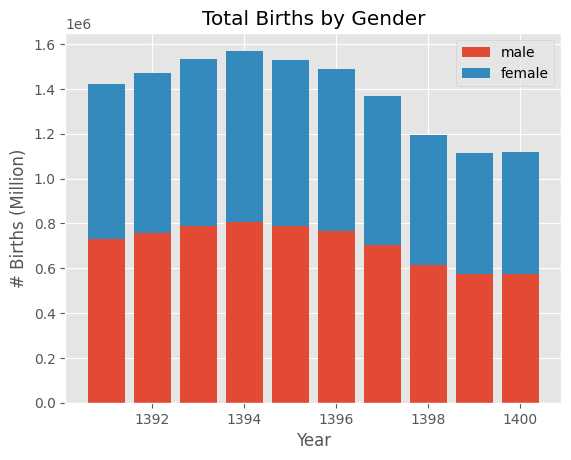

In [15]:
command_male = "SELECT year, sum(male) FROM births GROUP BY year ORDER BY year"
command_female = "SELECT year, sum(female) FROM births GROUP BY year ORDER BY year"
df_male = pd.DataFrame(db.select(command_male), columns=["year", "births"])
df_female = pd.DataFrame(db.select(command_female), columns=["year", "births"])

plt.bar(df_male['year'], df_male['births'], label="male")
plt.bar(df_female['year'], df_female['births'], bottom=df_male['births'], label="female")

plt.xlabel("Year")
plt.ylabel("# Births (Million)")
plt.title("Total Births by Gender")
plt.legend()
plt.show()

<blockquote>

As the chance of a new born being male or female is around 50%, so both male and female births are similar to the total births we saw before. About half of each year are male and the other half female. Most births in both genders happen in 94 and least in the final years.

##### **c. Most births in last five years**

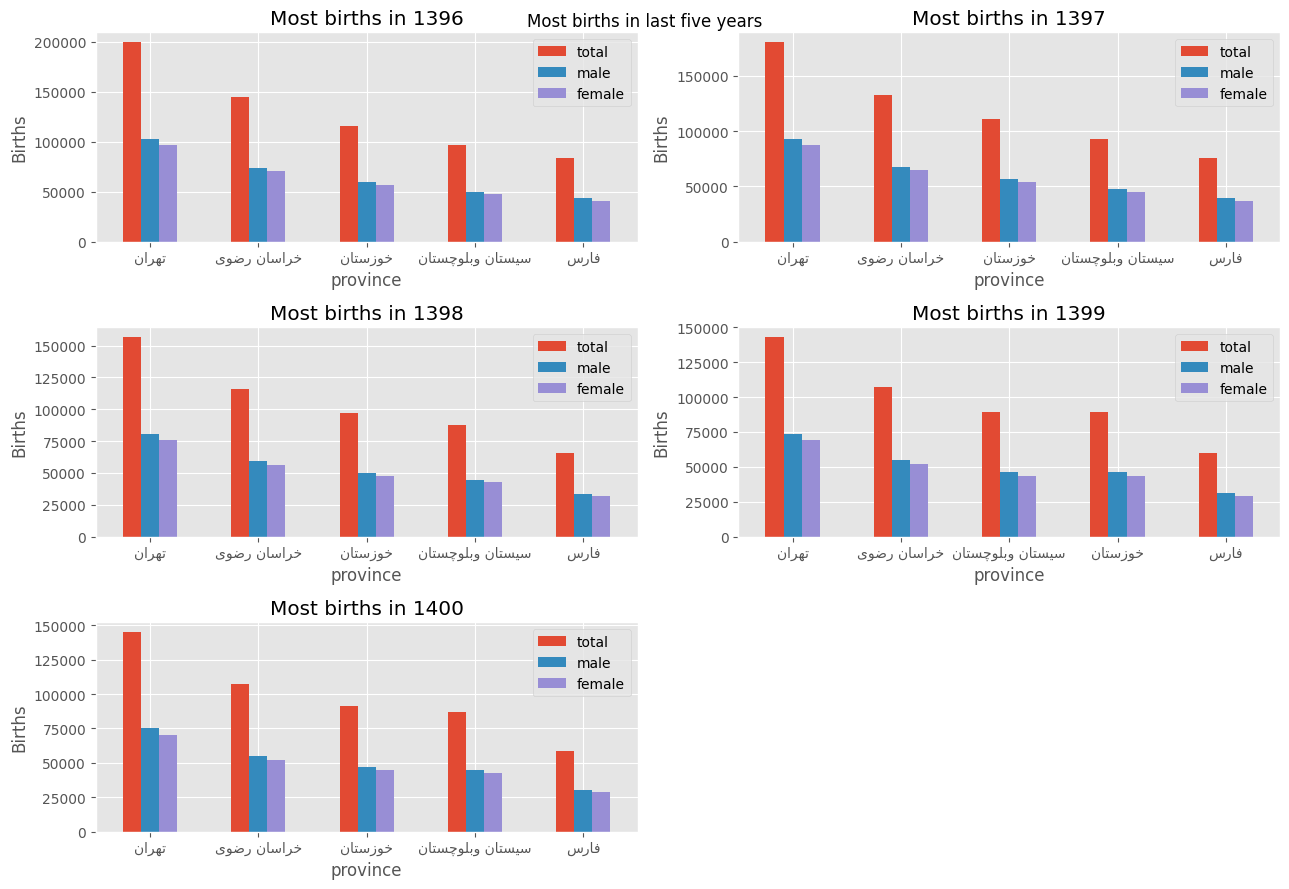

In [72]:
plt.figure(figsize=(13, 9))
for i, year in enumerate(range(1396, 1401)):
    year_df = None
    for gender in ["total", "male", "female"]:
        command = f"""
            SELECT province, sum({gender}) FROM births 
            WHERE year={year}
            GROUP BY province
            ORDER BY sum({gender}) DESC
            LIMIT 5
        """
        df = pd.DataFrame(db.select(command), columns=["province", gender])
        if year_df is None:
            year_df = df
        else:
            assert (df["province"] == df["province"]).all()
            year_df[gender] = df[gender]
        
    year_df["province"] = year_df["province"].apply(lambda x: get_display(arabic_reshaper.reshape(x)))
    plt.subplot(3, 2, i+1)
    year_df.plot(kind="bar", x="province", rot=0, ax=plt.gca())
    plt.title(f"Most births in {year}")
    plt.ylabel("Births")
    
plt.tight_layout()
plt.suptitle("Most births in last five years")
plt.show()

<blockquote>

Basically, the provinces that had larger population have larger #births as well. Tehran as the most populated city in Iran, has the most number of births as well during this time period. The interesting insight is that first of all male births are more in this data than female. Moreover, Khuzestan and Sistan changed their places in 1399 showing that Sistan had more births than Khuzestan in that specific year (1399). As asserted in the code, the order of most births in a year does not change based on total/male/female and if one is greater we see that all other are greater as well. That allowed us to plot all three in one place. (Otherwise if for instance P1 had more male but less female than P2, we had to plot two different figures to show the order change)

##### **d. Least births in last five years**

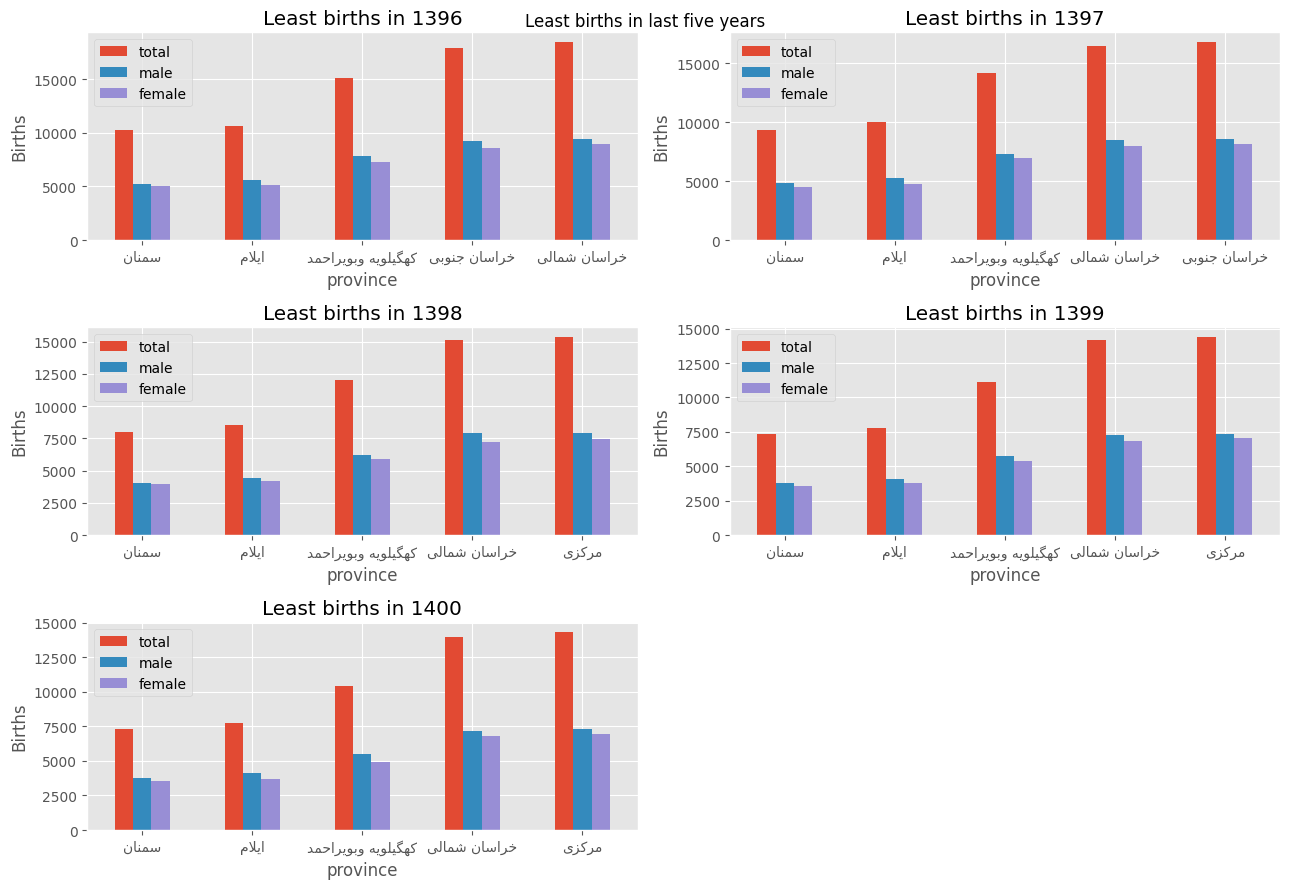

In [90]:
plt.figure(figsize=(13, 9))
for i, year in enumerate(range(1396, 1401)):
    year_df = None
    for gender in ["total", "male", "female"]:
        command = f"""
            SELECT province, sum({gender}) FROM births 
            WHERE year={year}
            GROUP BY province
            ORDER BY sum({gender})
            LIMIT 5
        """
        df = pd.DataFrame(db.select(command), columns=["province", gender])
        if year_df is None:
            year_df = df
        else:
            assert (df["province"] == df["province"]).all()
            year_df[gender] = df[gender]
        
    year_df["province"] = year_df["province"].apply(lambda x: get_display(arabic_reshaper.reshape(x)))
    plt.subplot(3, 2, i+1)
    year_df.plot(kind="bar", x="province", rot=0, ax=plt.gca())
    plt.title(f"Least births in {year}")
    plt.ylabel("Births")
    
plt.tight_layout()
plt.suptitle("Least births in last five years")
plt.show()

<blockquote>
    
Here we see that Semnan has the least number of births in all these 5 years. Khorasan Shomali and Jonubi change places in 96 and 97. Jonubi actually goes out of least 5 meaning it had beed growing. Therefore, Markazi comes to the least 5 after 98. The order has not changed since 98. Again as asserted in the code, the order of least births in a year does not change based on total/male/female and if one is smaller we see that all other are smaller as well.

##### **e. Most Birth-rate**

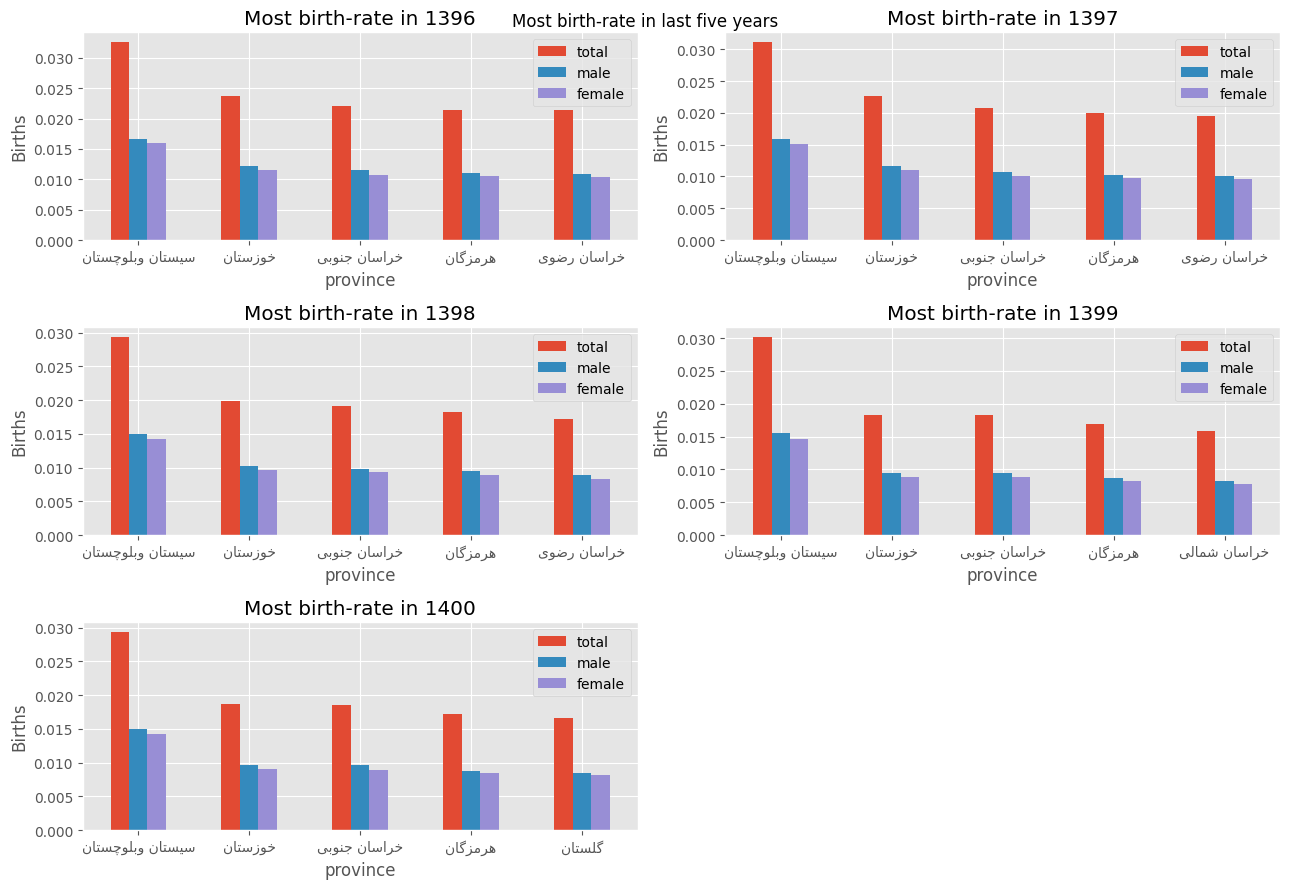

In [91]:
plt.figure(figsize=(13, 9))
for i, year in enumerate(range(1396, 1401)):
    year_df = None
    
    for gender in ["total", "male", "female"]:
        command = f"""
            SELECT births.province, sum({gender})::float/population.population
            FROM births INNER JOIN population ON births.province = population.province
            WHERE year={year}
            GROUP BY births.province, population.population
            ORDER BY sum({gender})::float/population.population DESC
            LIMIT 5
        """
        df = pd.DataFrame(db.select(command), columns=["province", gender])
        df[gender] = df[gender].astype(float)
        if year_df is None:
            year_df = df
        else:
            assert (df["province"] == df["province"]).all()
            year_df[gender] = df[gender]
        
    year_df["province"] = year_df["province"].apply(lambda x: get_display(arabic_reshaper.reshape(x)))
    plt.subplot(3, 2, i+1)
    year_df.plot(kind="bar", x="province", rot=0, ax=plt.gca())
    plt.title(f"Most birth-rate in {year}")
    plt.ylabel("Births")
    
plt.tight_layout()
plt.suptitle("Most birth-rate in last five years")
plt.show()

<blockquote>

Sistan has the most birth-rate. It means they have more births with respect to their total population. This division made this insight possible because in the last analysis, Tehran which had more population had more births as well. Now we can see that Tehran is not having many births considering the population of Tehran. First 4 positions are fixed during this time period, howver the 5th place changes among Khorasan Razavi, Shomali and Golestan. Most of these are also from south of Iran geographically.

##### **f. Least Birth-rate**

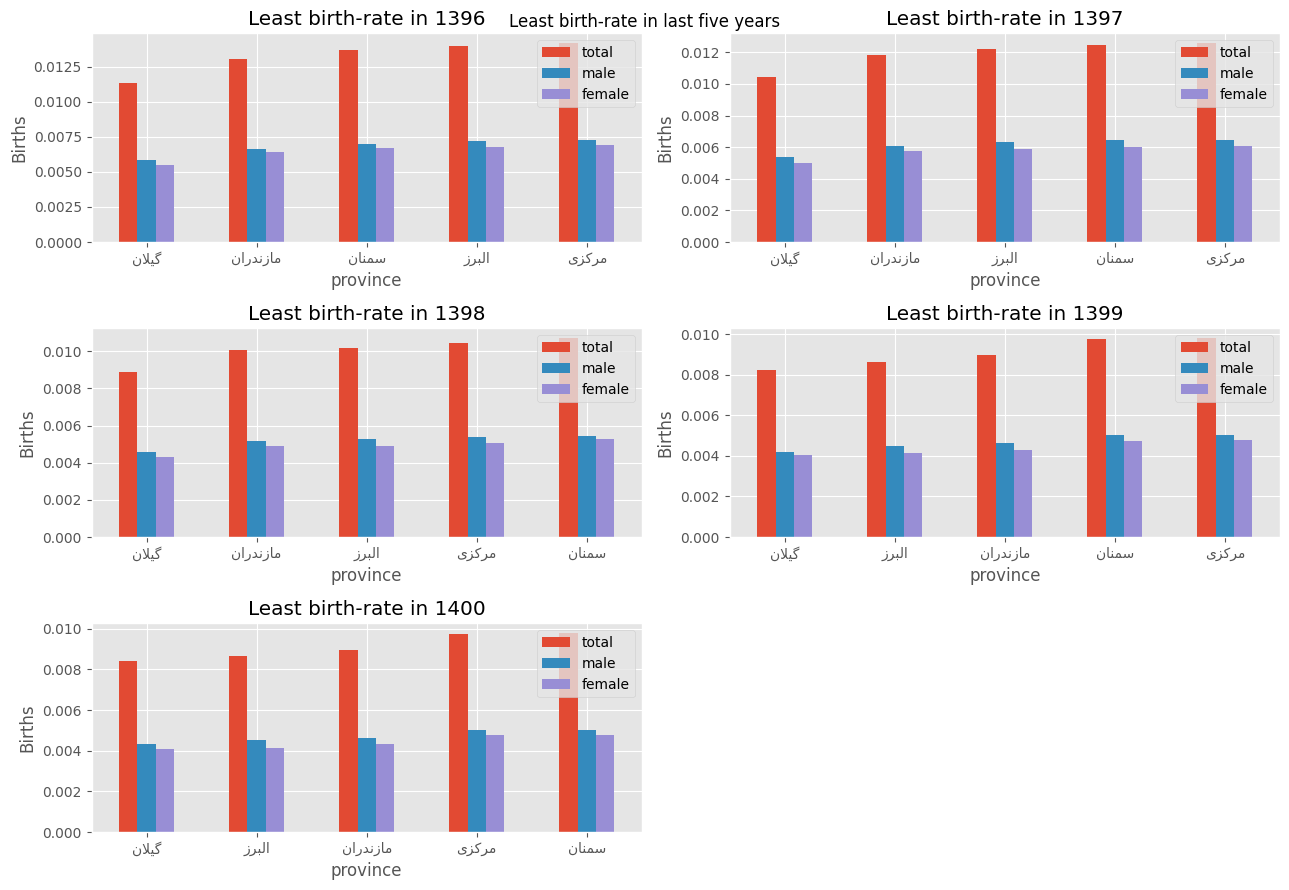

In [92]:
plt.figure(figsize=(13, 9))
for i, year in enumerate(range(1396, 1401)):
    year_df = None
    
    for gender in ["total", "male", "female"]:
        command = f"""
            SELECT births.province, sum({gender})::float/population.population
            FROM births INNER JOIN population ON births.province = population.province
            WHERE year={year}
            GROUP BY births.province, population.population
            ORDER BY sum({gender})::float/population.population
            LIMIT 5
        """
        df = pd.DataFrame(db.select(command), columns=["province", gender])
        df[gender] = df[gender].astype(float)
        if year_df is None:
            year_df = df
        else:
            assert (df["province"] == df["province"]).all()
            year_df[gender] = df[gender]
        
    year_df["province"] = year_df["province"].apply(lambda x: get_display(arabic_reshaper.reshape(x)))
    plt.subplot(3, 2, i+1)
    year_df.plot(kind="bar", x="province", rot=0, ax=plt.gca())
    plt.title(f"Least birth-rate in {year}")
    plt.ylabel("Births")
    
plt.tight_layout()
plt.suptitle("Least birth-rate in last five years")
plt.show()

<blockquote>
    
Gilan has the least birth-rate. the other 4 provinces change places among themselves on the years and their rate are closer together. Unlike the most birth-rate, these provinces are mostly located in the north of Iran.

##### **g. Birth number and rate in each season!**

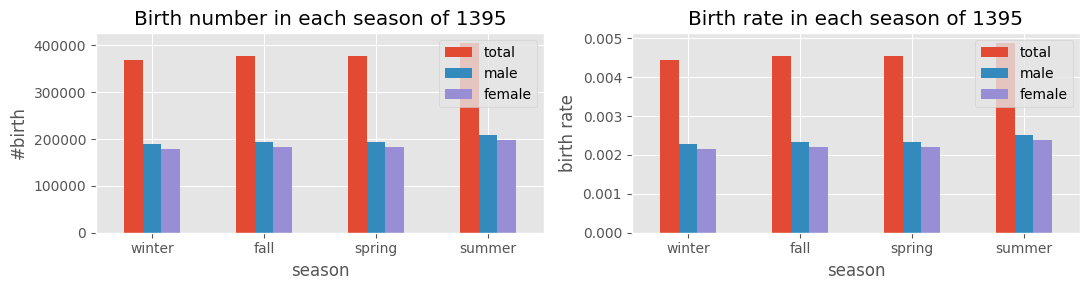

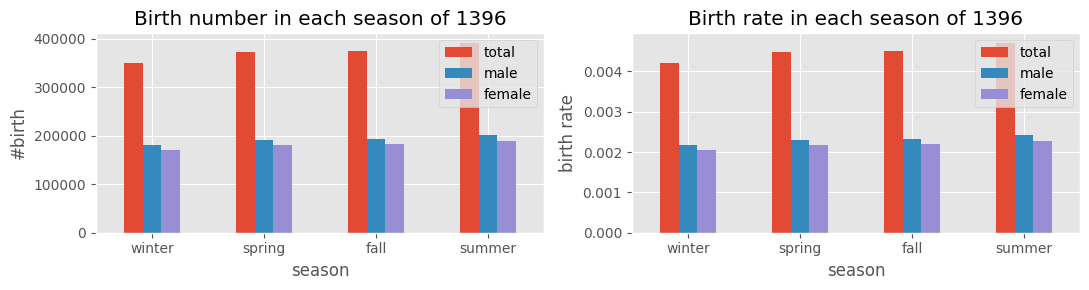

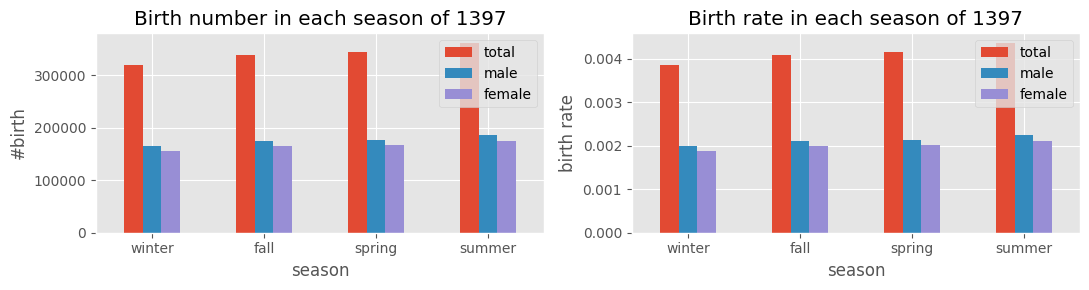

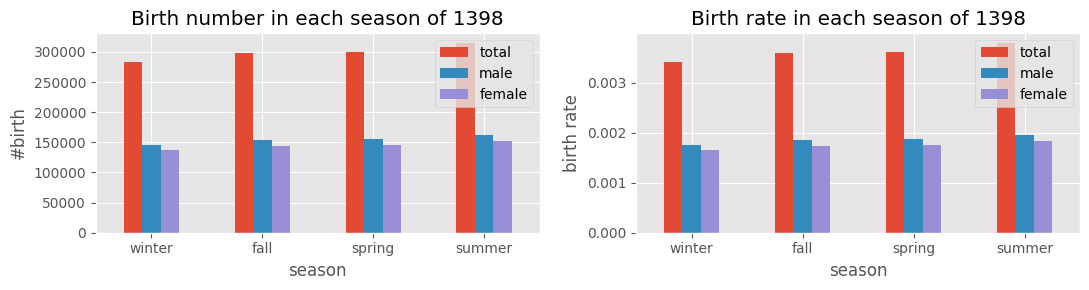

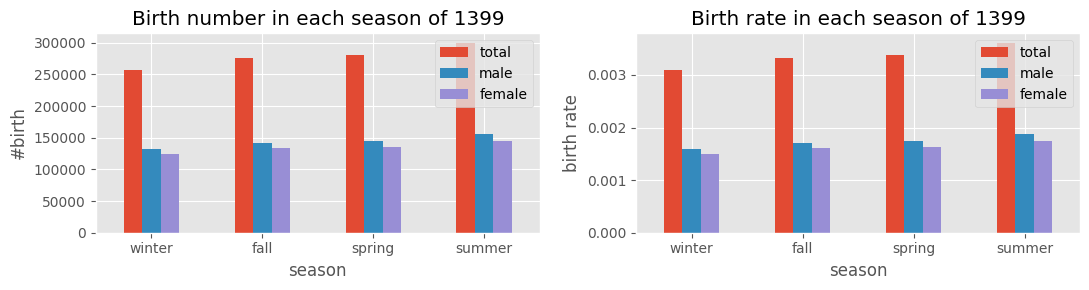

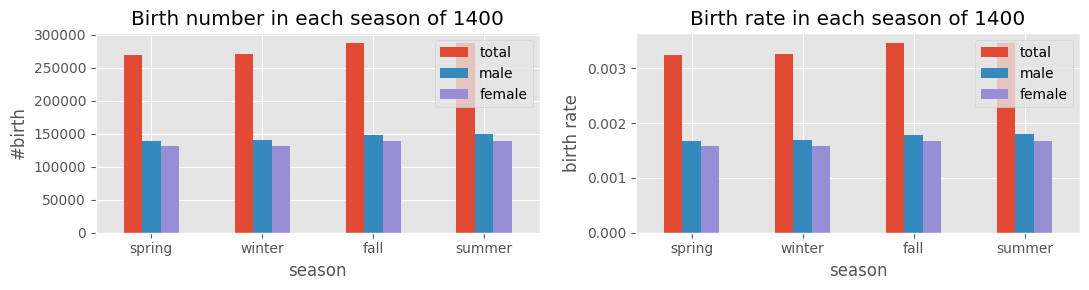

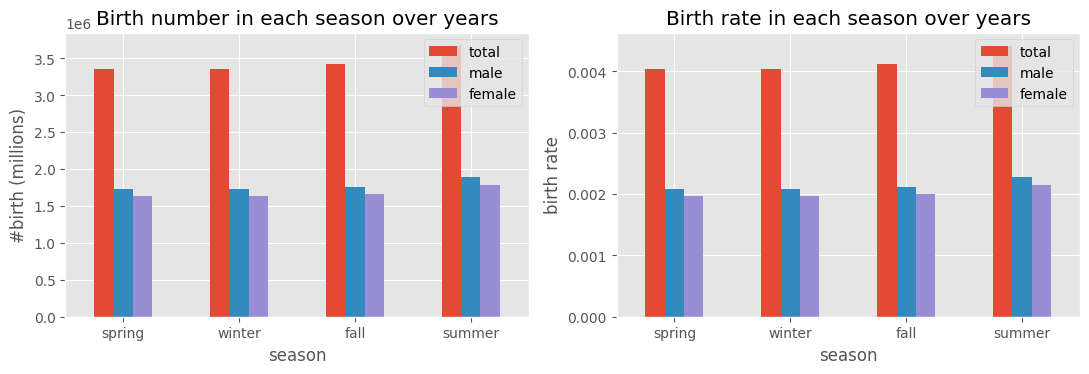

In [126]:
for year in range(1395, 1401):
    plt.figure(figsize=(11, 3))
    season_df = None
    for gender in ["total", "male", "female"]:
        command = f"""
            SELECT births.season, sum({gender})
            FROM births
            WHERE year={year}
            GROUP BY births.season
            ORDER BY sum({gender})
        """
        df = pd.DataFrame(db.select(command), columns=["season", gender])
        if season_df is None:
            season_df = df
        else:
            season_df[gender] = df[gender]
    plt.subplot(1, 2, 1)
    season_df.plot(kind="bar", x="season", rot=0, ax=plt.gca())
    plt.title(f"Birth number in each season of {year}")
    plt.ylabel("#birth")

    season_df = None
    for gender in ["total", "male", "female"]:
        command = f"""
            SELECT births.season, sum({gender})::float/sum(population.population)
            FROM births INNER JOIN population ON births.province = population.province
            WHERE year={year}
            GROUP BY births.season
            ORDER BY sum({gender})
        """
        df = pd.DataFrame(db.select(command), columns=["season", gender])
        if season_df is None:
            season_df = df
        else:
            season_df[gender] = df[gender]
    plt.subplot(1, 2, 2)
    season_df.plot(kind="bar", x="season", rot=0, ax=plt.gca())
    plt.title(f"Birth rate in each season of {year}")
    plt.ylabel("birth rate")

    plt.tight_layout()
    plt.show()

plt.figure(figsize=(11, 4))
season_df = None
for gender in ["total", "male", "female"]:
    command = f"""
        SELECT births.season, sum({gender})
        FROM births
        GROUP BY births.season
        ORDER BY sum({gender})
    """
    df = pd.DataFrame(db.select(command), columns=["season", gender])
    if season_df is None:
        season_df = df
    else:
        season_df[gender] = df[gender]
plt.subplot(1, 2, 1)
season_df.plot(kind="bar", x="season", rot=0, ax=plt.gca())
plt.title("Birth number in each season over years")
plt.ylabel("#birth (millions)")

season_df = None
for gender in ["total", "male", "female"]:
    command = f"""
        SELECT births.season, sum({gender})::float/sum(population.population)
        FROM births INNER JOIN population ON births.province = population.province
        GROUP BY births.season
        ORDER BY sum({gender})
    """
    df = pd.DataFrame(db.select(command), columns=["season", gender])
    if season_df is None:
        season_df = df
    else:
        season_df[gender] = df[gender]
plt.subplot(1, 2, 2)
season_df.plot(kind="bar", x="season", rot=0, ax=plt.gca())
plt.title("Birth rate in each season over years")
plt.ylabel("birth rate")

plt.tight_layout()
plt.show()

<blockquote>

Summer has the most births
Overall, the order is Spring, Winter, Fall, and Summer from lowest to highest birth rate.
It is worth mentioning that in this question where the provinces are not required, the birth rate and birth count does not show more information for comparing seasons as all the seasons are divided by the population of the country and all are only scaled down by a fixed value! 

## Section 3  cursor.connect(**params)

<blockquote>

Cursors are created by the connection.cursor() method: they are bound to the connection for the entire lifetime and all the commands are executed in the context of the database session wrapped by the connection.
    
cursor does not have any method called "connect"! https://www.psycopg.org/docs/cursor.html
    
connection has cursor(): https://www.psycopg.org/docs/connection.html#connection.cursor

psycopg2 cursors are pretty lightweight (they don't represent an actual server-side, DECLAREd cursor, unless you pass a name argument). So making multiple of the client side cursors should not have big complications except using some memory.

Cursors are made for large data and being thread safe (which the connection is not).
If the dataset is too large to be practically handled on the client side, it is possible to create a server side cursor. Using this kind of cursor it is possible to transfer to the client only a controlled amount of data, so that a large dataset can be examined without keeping it entirely in memory. https://www.psycopg.org/docs/usage.html#server-side-cursors
    
It is possible to create a WITH HOLD cursor (Default is WITHOUT HOLD) by specifying a True value for the withhold parameter to cursor() or by setting the withhold attribute to True before calling execute() on the cursor. It is extremely important to always close() such cursors, otherwise they will continue to hold server-side resources until the connection will be eventually closed.
    
So the issue with making and using many cursors is the server-side resources they will use. And the solution is to close each of them afterwards or use "with" command like
```
    with cur as con.cursor():
        cur.execute(...)
```
https://stackoverflow.com/questions/62372081/what-is-the-advantage-of-using-multiple-cursors-in-psycopg2-for-postgresql-queri

## **Part2 - Working with QGIS**

#### **Section A: Load Data**

In [132]:
class QGIS_DB:
    def __init__(self):
        self.conn = None
    
    def execute(self, command, close_after=False):
        try:
            if self.conn is None:
                self.conn = psycopg2.connect(database="mohsen_db", user="postgres", password="1234", host="localhost")
            self.conn = self.conn
            curser = self.conn.cursor()
            curser.execute(command)
            curser.close()
            self.conn.commit()
        except(Exception, psycopg2.DatabaseError) as error:
            print(error)
        finally:
            if self.conn is not None:
                if close_after:
                    self.conn.close()
                    self.conn = None
    
    def select(self, command):
        data = None
        try:
            conn = None
            conn = psycopg2.connect(database="mohsen_db", user="postgres",
                                    password="1234", host="localhost")
            curser = conn.cursor()
            curser.execute(command)
            data = curser.fetchall()
            curser.close()
        except(Exception, psycopg2.DatabaseError) as error:
            print(error)
        finally:
            if conn is not None:
                conn.close()
            return data
    
    def load_sql(self):
        files = [
            "./Datasets/Part2_QGIS/Iran_Country.sql", 
            "./Datasets/Part2_QGIS/Iran_County.sql", 
            "./Datasets/Part2_QGIS/Iran_States.sql", 
            "./Datasets/Part2_QGIS/Iran_Inland_Water.sql", 
        ]
        for file_path in tqdm(files):
            with open(file_path) as f:
                for line in f:
                    self.execute(line.strip())

db = QGIS_DB()
db.load_sql()

  0%|          | 0/4 [00:00<?, ?it/s]

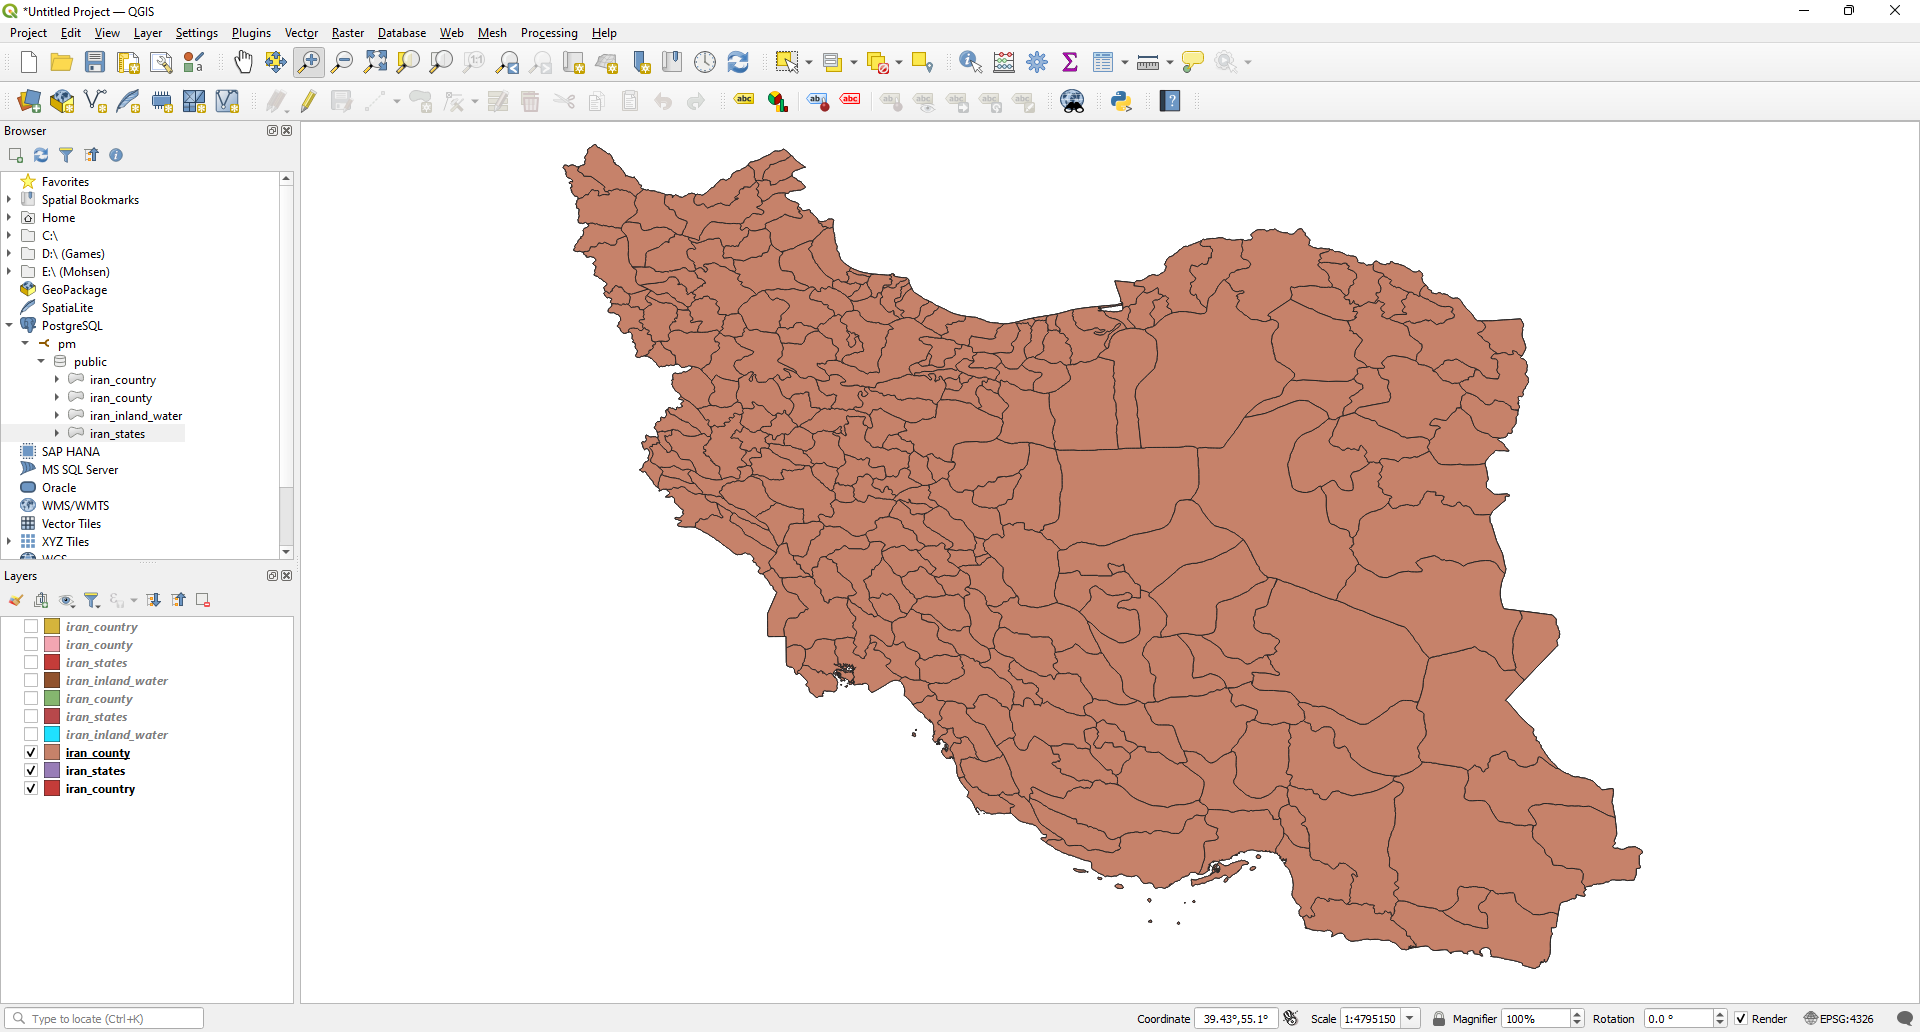

#### **Section B: Answer Questions**

In [135]:
### a
command = """
    SELECT name_0, name_1, name_2 FROM iran_county
    WHERE ST_Intersects(iran_county.wkb_geometry, ST_SetSRID(ST_Point(51.3380650, 35.6997300), 4326))  
"""
db.select(command)

[('Iran', 'Tehran', 'Theran')]

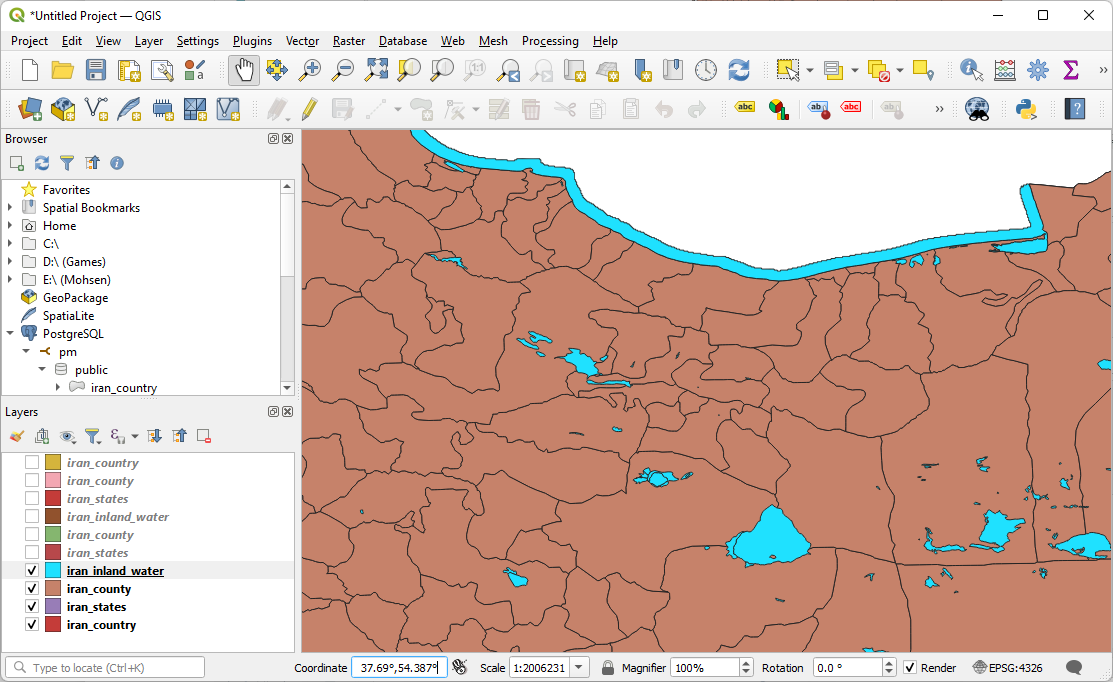

In [136]:
### b
command = """
    SELECT name_0, name_1, name_2 FROM iran_county
    WHERE ST_Intersects(iran_county.wkb_geometry, ST_SetSRID(ST_Point(52.8904157, 29.9351594), 4326))  
"""
db.select(command)

[('Iran', 'Fars', 'Marvdasht')]

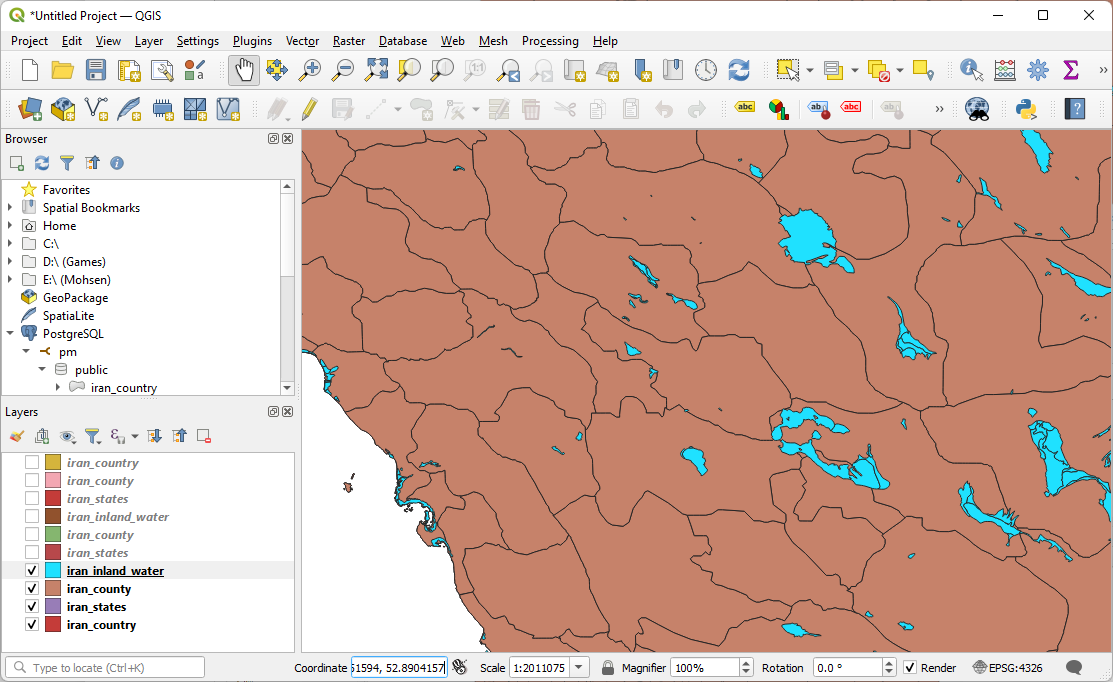

### c
Added "./Datasets/Part2_QGIS/Iran_Inland_Water.sql" to load_sql

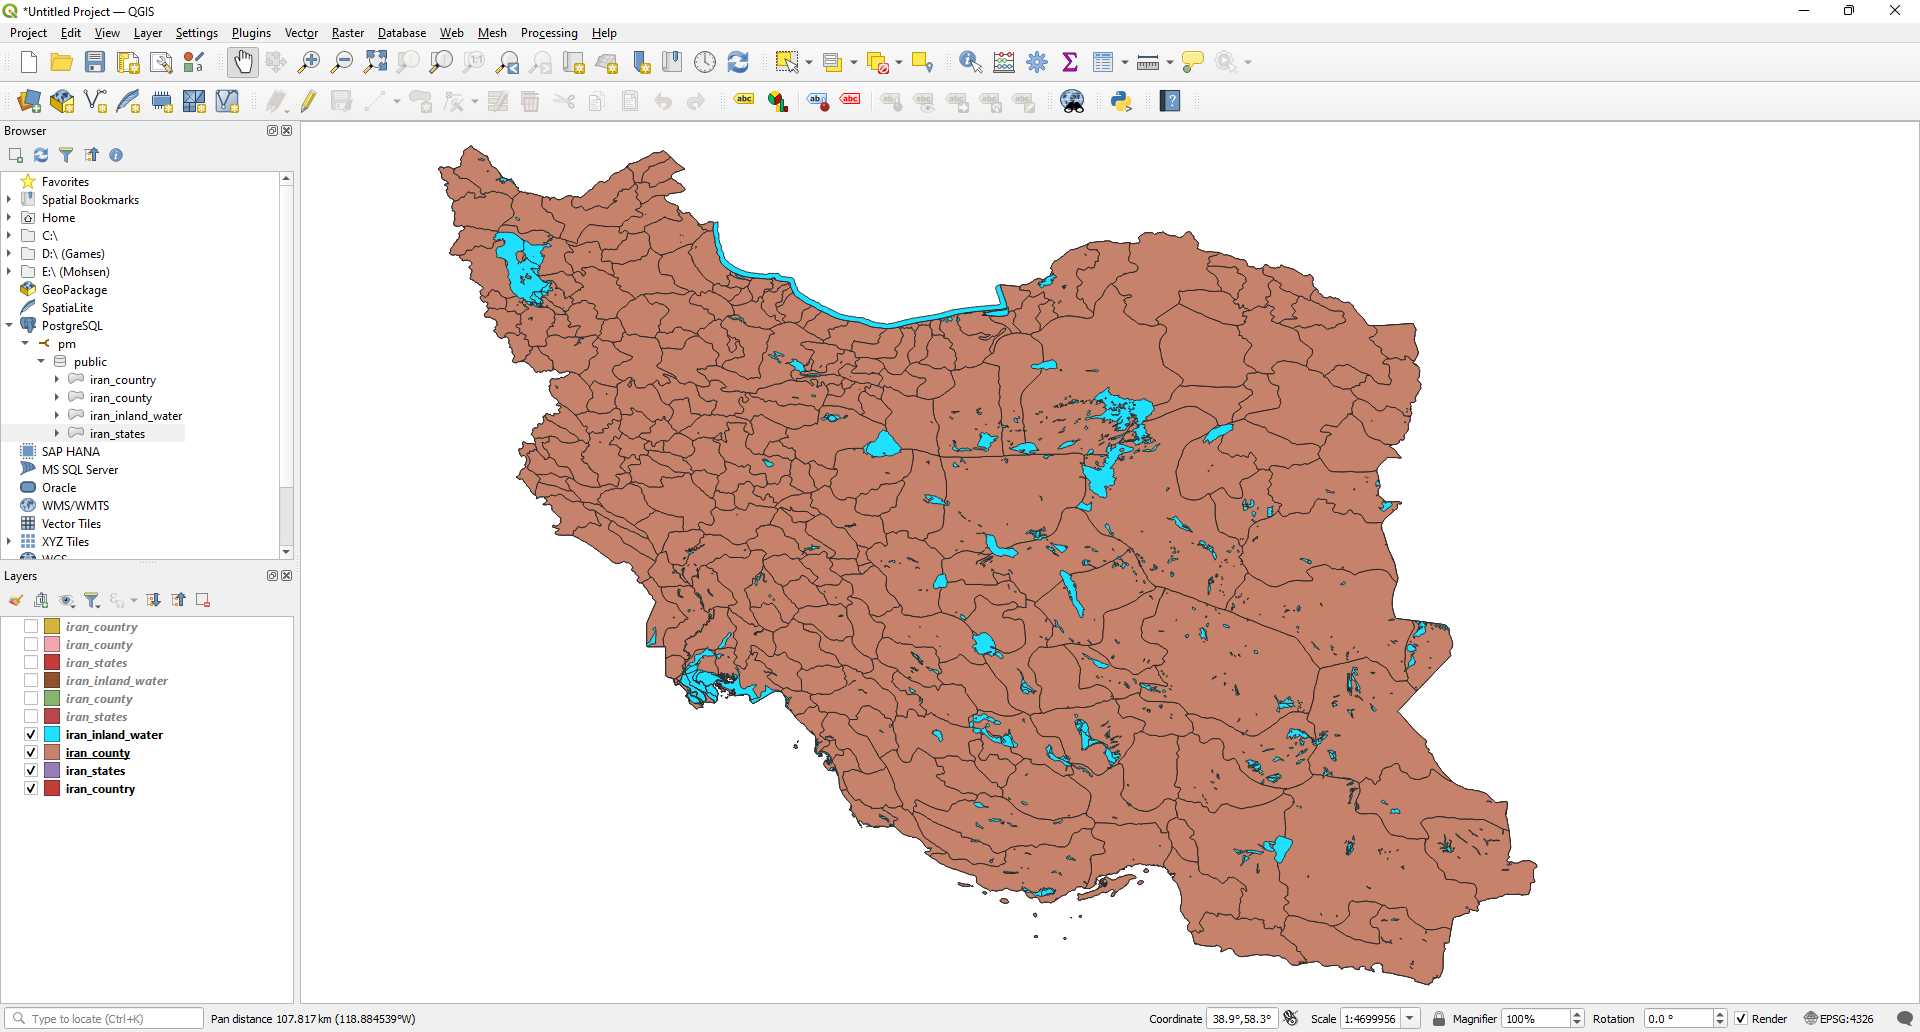

In [141]:
### d
# PC
command = """
    SELECT iran_county.name_0, iran_county.name_1, iran_county.name_2, iran_inland_water.name FROM iran_county, iran_inland_water
    WHERE ST_Intersects(iran_inland_water.wkb_geometry, ST_SetSRID(ST_Point(51.270365, 35.728517), 4326)) and  ST_Intersects(iran_county.wkb_geometry, ST_SetSRID(ST_Point(51.270365, 35.728517), 4326))  
"""
db.select(command)


[('Iran', 'Tehran', 'Theran', 'UNK')]

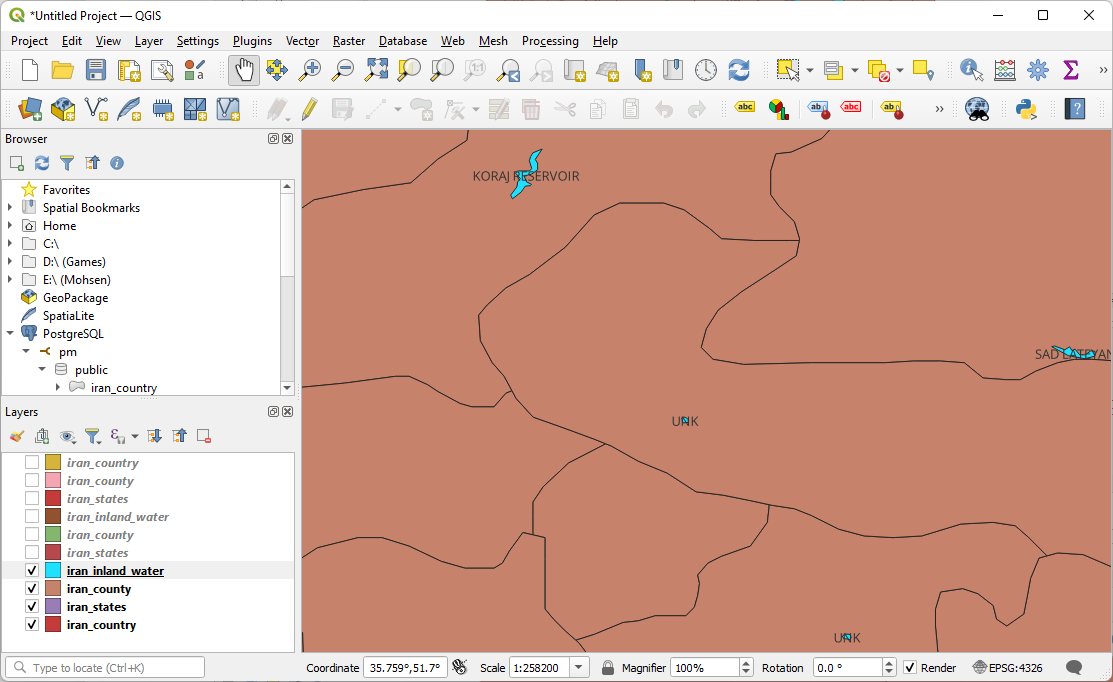

In [142]:
command = """
    SELECT iran_county.name_0, iran_county.name_1, iran_county.name_2, iran_inland_water.name FROM iran_county, iran_inland_water
    WHERE ST_Intersects(iran_inland_water.wkb_geometry, ST_SetSRID(ST_Point(45.4533, 37.6186), 4326)) and  ST_Intersects(iran_county.wkb_geometry, ST_SetSRID(ST_Point(45.4533, 37.6186), 4326))
"""
db.select(command)

[('Iran', 'East Azarbaijan', 'Shabestar', 'DARYACHEH-YE ORUMIYEH')]

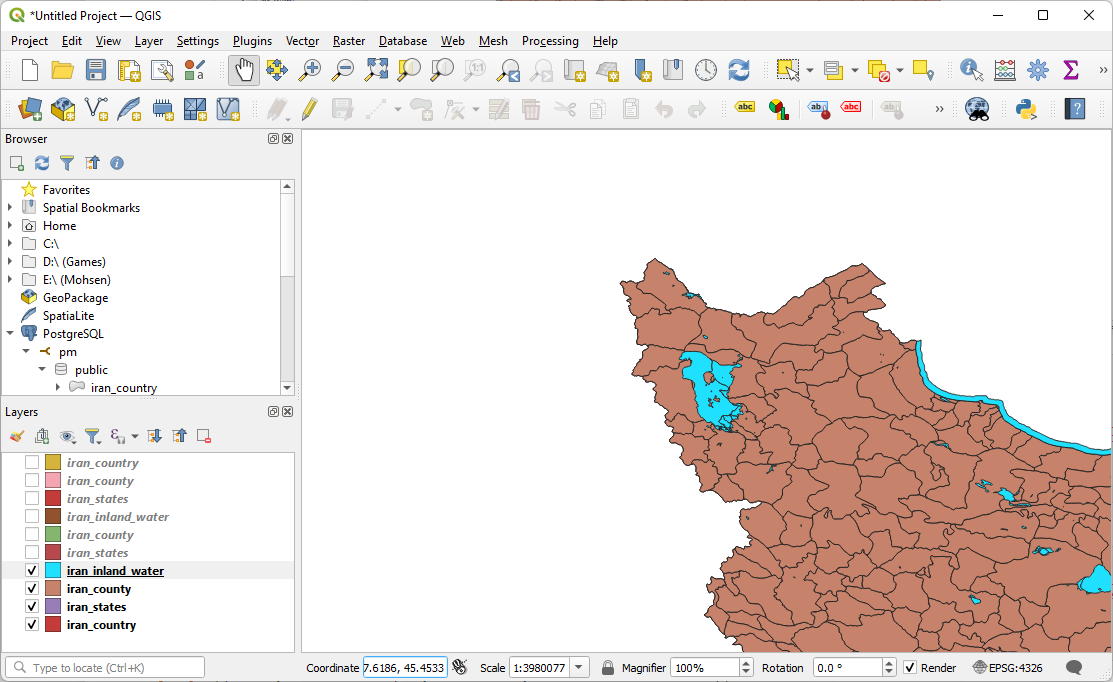

In [ ]:
35.728517, 51.270365